# _Visualizations 100k Tweets Sample: Jan 20, 2020_

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
from pathlib import Path
import numpy as np
import random
import os

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

## _Load in Data_

In [3]:
# assign as Path variable
path = Path(os.getcwd())
print(path)

/Users/jai/Documents/Private-projects/Russian-Disinformation


In [27]:
# load in 100k JSON data from Jan. 20, 2020
df = pd.read_json(path/"json-data/100k_tweetsjan20.json", orient="split")

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 14 columns):
full_text             100000 non-null object
clean_tweet           100000 non-null object
retweet               100000 non-null bool
num_mentions          100000 non-null int64
mentions_usernames    100000 non-null object
num_links             100000 non-null int64
num_hashtags          100000 non-null int64
hashtags_used         100000 non-null object
uppercase_words       100000 non-null int64
num_characters        100000 non-null int64
avg_lenwords          98722 non-null float64
num_nouns             100000 non-null int64
vader_compound        100000 non-null float64
label                 100000 non-null object
dtypes: bool(1), float64(2), int64(6), object(5)
memory usage: 10.8+ MB


In [29]:
# check out first few observations
df[:5]

,full_text,clean_tweet,retweet,num_mentions,mentions_usernames,num_links,num_hashtags,hashtags_used,uppercase_words,num_characters,avg_lenwords,num_nouns,vader_compound,label
0,"On October 16th, one supporter will get a chan...",october supporter will chance watch debate wit...,False,0,,1,0,,6,127,4.3333,4,0.204,verified
1,OMG I’ve been dying to tell you about the new ...,been dying tell about cozy collection pajamas ...,False,1,@skims,2,0,,10,228,4.0000,8,0.184,verified
2,The #SchumerStandard for filling #SCOTUS vacan...,schumer standard filling scotus vacancies,False,0,,1,2,"#SchumerStandard,#SCOTUS",3,75,7.1667,1,0.000,verified
3,RT @alicia_keysbr: When someone says #TeamAlic...,when someone says team alicia strongest alread...,True,1,@alicia_keysbr,1,1,#TeamAlicia,2,115,4.9167,1,0.248,verified
4,"“Whether it is because of distance, health pro...",whether because distance health problems work ...,False,1,@NYTParenting,1,0,,3,260,5.2000,10,0.051,verified


In [30]:
# replace missing values in mentions usernames column
df["mentions_usernames"] = df["mentions_usernames"].replace(r"", "none", regex=True)
# replace missing values in hashtags_used column
df["hashtags_used"] = df["hashtags_used"].replace(r"", "none", regex=True)

# see first few observations
df[:5]

,full_text,clean_tweet,retweet,num_mentions,mentions_usernames,num_links,num_hashtags,hashtags_used,uppercase_words,num_characters,avg_lenwords,num_nouns,vader_compound,label
0,"On October 16th, one supporter will get a chan...",october supporter will chance watch debate wit...,False,0,none,1,0,none,6,127,4.3333,4,0.204,verified
1,OMG I’ve been dying to tell you about the new ...,been dying tell about cozy collection pajamas ...,False,1,@skims,2,0,none,10,228,4.0000,8,0.184,verified
2,The #SchumerStandard for filling #SCOTUS vacan...,schumer standard filling scotus vacancies,False,0,none,1,2,"#SchumerStandard,#SCOTUS",3,75,7.1667,1,0.000,verified
3,RT @alicia_keysbr: When someone says #TeamAlic...,when someone says team alicia strongest alread...,True,1,@alicia_keysbr,1,1,#TeamAlicia,2,115,4.9167,1,0.248,verified
4,"“Whether it is because of distance, health pro...",whether because distance health problems work ...,False,1,@NYTParenting,1,0,none,3,260,5.2000,10,0.051,verified


In [31]:
# last check for any NaNs
df.isna().sum()

full_text                0
clean_tweet              0
retweet                  0
num_mentions             0
mentions_usernames       0
num_links                0
num_hashtags             0
hashtags_used            0
uppercase_words          0
num_characters           0
avg_lenwords          1278
num_nouns                0
vader_compound           0
label                    0
dtype: int64

In [32]:
# fix NaNs in avg_lenwords columns
df[df["avg_lenwords"].isna()][:3]

,full_text,clean_tweet,retweet,num_mentions,mentions_usernames,num_links,num_hashtags,hashtags_used,uppercase_words,num_characters,avg_lenwords,num_nouns,vader_compound,label
57,@joaonill : - ),,False,1,@joaonill,0,0,none,0,15,NaN,0,0.0,verified
114,@JamesLoren75 @mspennycrumb 👏🏻💚,,False,2,"@JamesLoren75,@mspennycrumb",0,0,none,0,31,NaN,0,0.0,verified
152,https://t.co/XphTlb12c2 https://t.co/q0fhqD4smy,,False,0,none,2,0,none,0,23,NaN,0,0.0,verified


In [33]:
# replace NaNs in column with 0
df["avg_lenwords"] = df["avg_lenwords"].fillna(0)

In [35]:
def sentiment_scores(text):
    '''
    Function that returns the compound VADER sentiment score for a given tweet.
    '''
    sentiment_score = SentimentIntensityAnalyzer().polarity_scores(text)["compound"]
    if sentiment_score >= 0.5:
        return sentiment_score, "high_pos"
    elif 0.05 < sentiment_score < 0.5:
        return sentiment_score, "low_pos"
    elif -0.05 <= sentiment_score <= 0.05:
        return sentiment_score, "neutral"
    elif -0.05 > sentiment_score > -0.5:
        return sentiment_score, "low_neg"
    else:
        return sentiment_score, "high_neg"

## _Visualizations_

In [43]:
font = {
    'style': 'italic',
    'color': 'black',
    'fontsize': 28
}

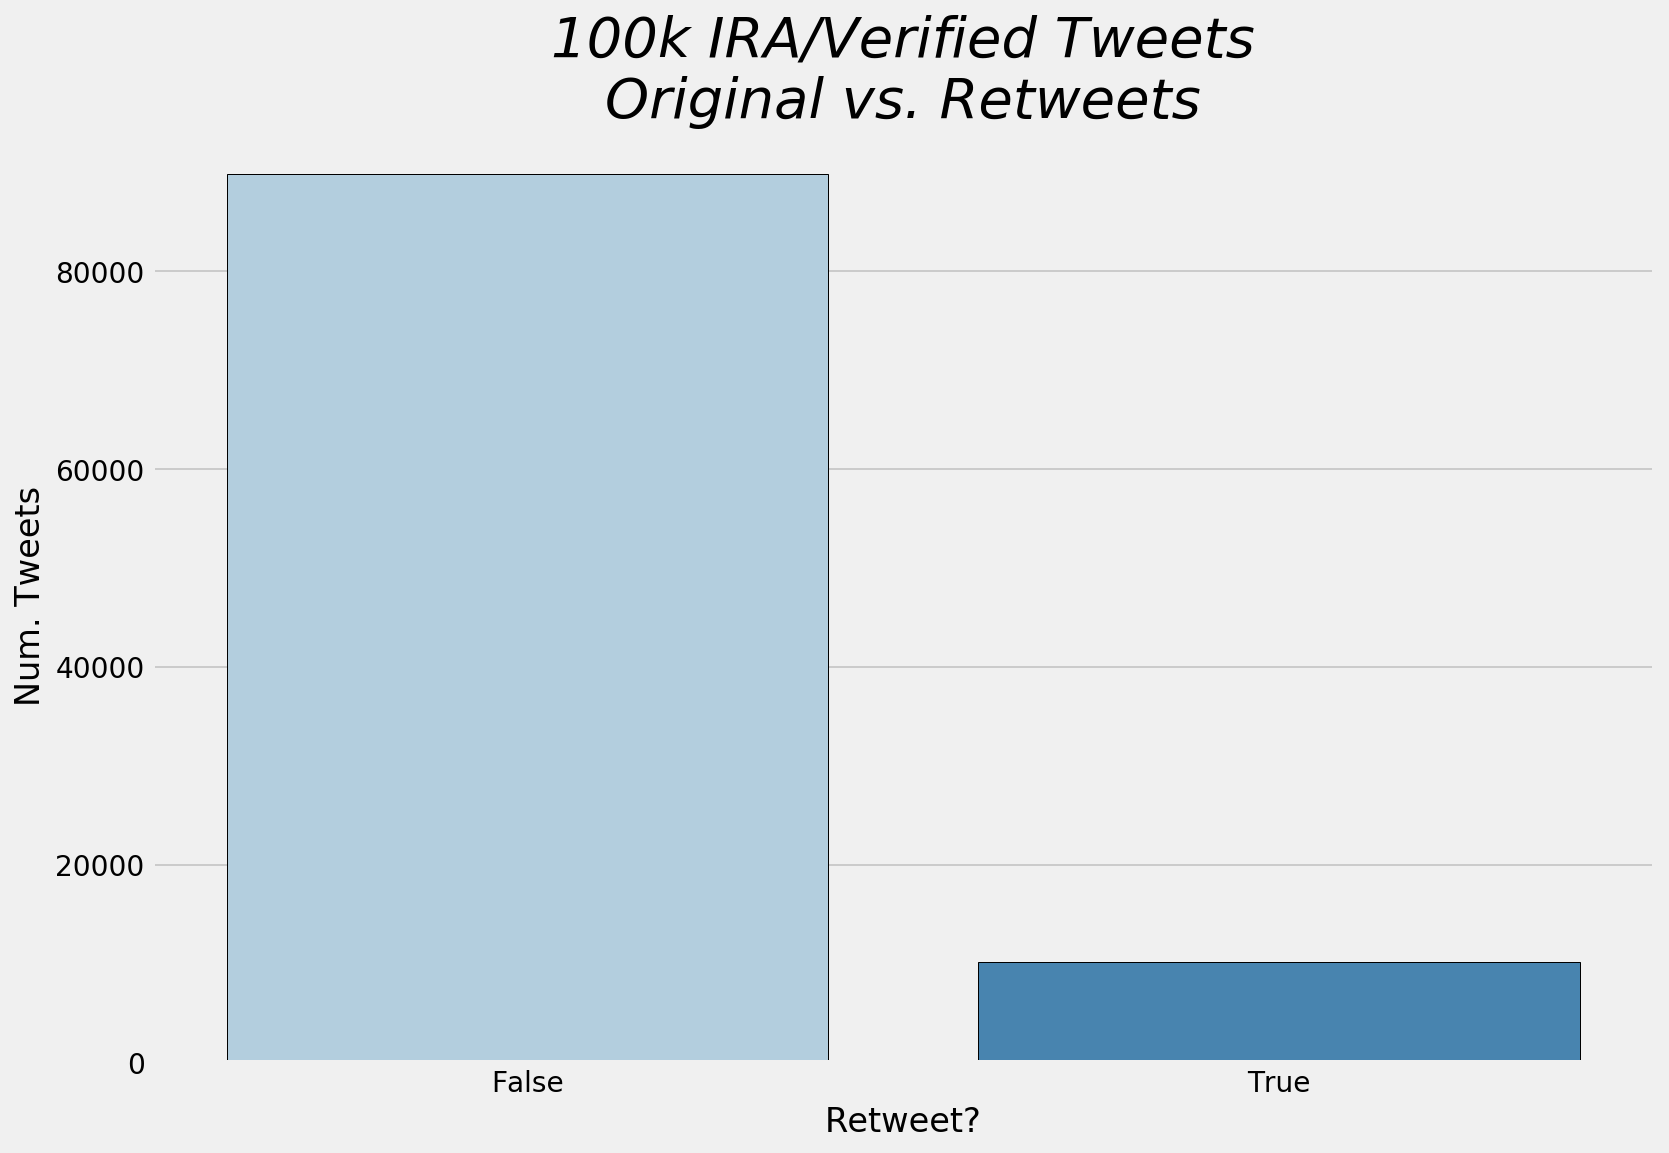

In [50]:
plt.figure(figsize=(12,8))
ax = sns.countplot(
    x="retweet",
    edgecolor="black",
    palette="Blues",
    data=df)
ax.set(xlabel='Retweet?', ylabel='Num. Tweets')
plt.title(label="100k IRA/Verified Tweets\nOriginal vs. Retweets", fontdict=font);

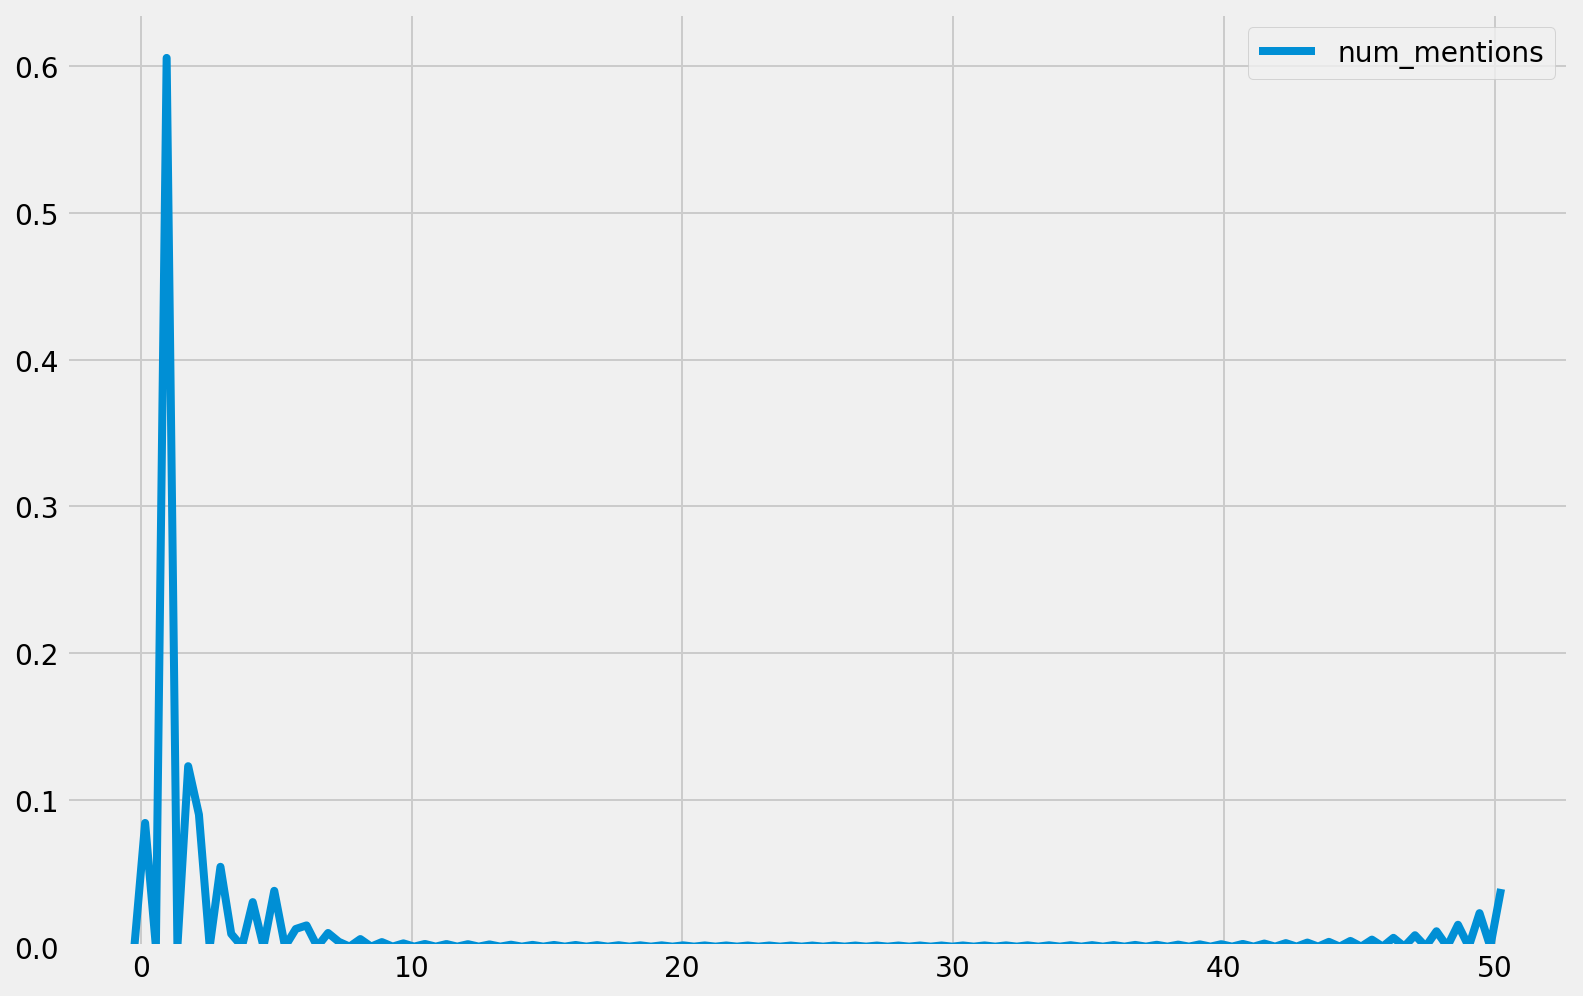

In [55]:
plt.figure(figsize=(12,8))
ax = sns.kdeplot(df["num_mentions"])

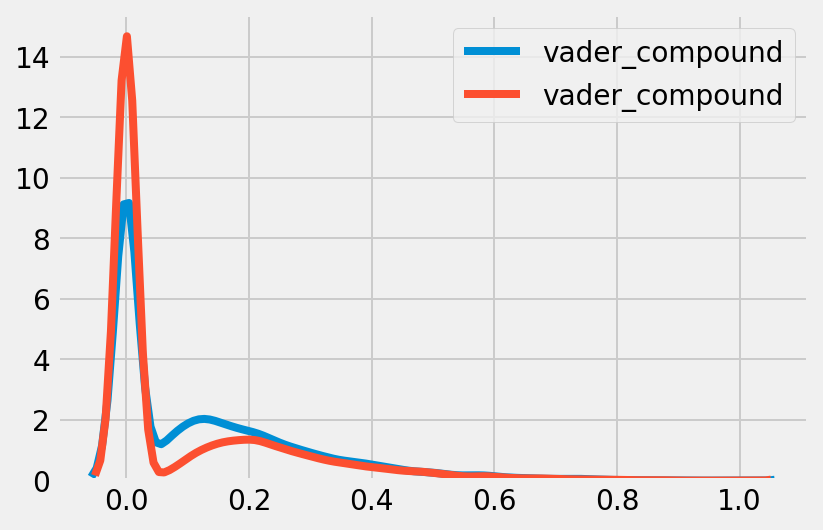

In [61]:
ax1 = sns.kdeplot(df[df["label"] == "verified"]["vader_compound"])
ax2 = sns.kdeplot(df[df["label"] == "fake"]["vader_compound"])

36